# Federated Learning Lab (MOOC)

This notebook is organized to match the TP objectives:
1. **Getting started**: centralized ML vs classical FL vs decentralized FL.
2. **Cost measurement**: communication and computation costs on a tabular dataset, comparing a neural model vs a simpler model.
3. **Advanced cost analysis**: costs under different client selection rates and local epochs.


## Setup
We load metrics exported by the experiments (CSV logs).


In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


def save_fig(name: str) -> None:
    plt.savefig(plot_dir / name, dpi=200, bbox_inches='tight')

plt.style.use('seaborn-v0_8')

cwd = Path.cwd()
if (cwd / 'runs').exists():
    base = cwd / 'runs'
elif cwd.name == 'runs':
    base = cwd
else:
    base = cwd / 'runs'
    
plot_dir = base / 'plots'
plot_dir.mkdir(parents=True, exist_ok=True)

def load_global_metrics(run_path: Path) -> pd.DataFrame:
    global_csv = run_path / 'global_metrics.csv'
    metrics_csv = run_path / 'metrics.csv'
    if global_csv.exists():
        return pd.read_csv(global_csv)
    if metrics_csv.exists():
        return pd.read_csv(metrics_csv)
    raise FileNotFoundError(f'No global metrics CSV in {run_path}')

def load_comm_costs(run_path: Path):
    path = run_path / 'comm_costs.csv'
    return pd.read_csv(path) if path.exists() else None

def load_run_time(run_path: Path):
    path = run_path / 'run_metrics.csv'
    if not path.exists():
        return None
    df = pd.read_csv(path)
    row = df[df['metric'] == 'run_time_seconds']
    if row.empty:
        return None
    return float(row['value'].iloc[0])

def comm_to_mb(comm_df):
    if comm_df is None or comm_df.empty:
        return 0.0
    return (comm_df['comm_costs'].sum() * 4) / (1024**2)

def comm_to_kb(comm_df):
    if comm_df is None or comm_df.empty:
        return 0.0
    return (comm_df['comm_costs'].sum() * 4) / 1024


## 1) Getting Started: Centralized vs FL vs Decentralized
We compare the global metrics on MNIST (non‑IID) across three settings.

**Runs used**:
- Centralized: `runs/fluke_mnist_noniid_traces_centralized`
- Federated: `runs/fluke_mnist_noniid_traces`
- Decentralized: `runs/fluke_mnist_noniid_traces_FL_dec`


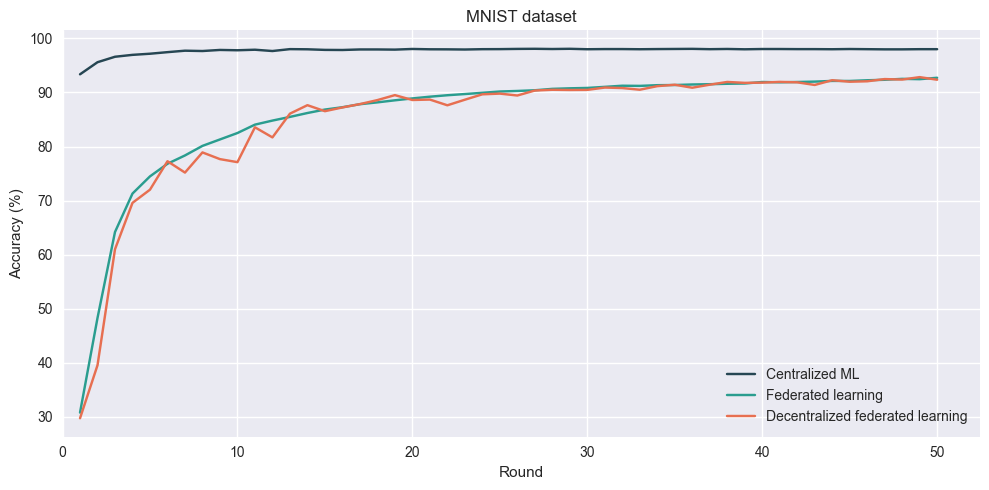

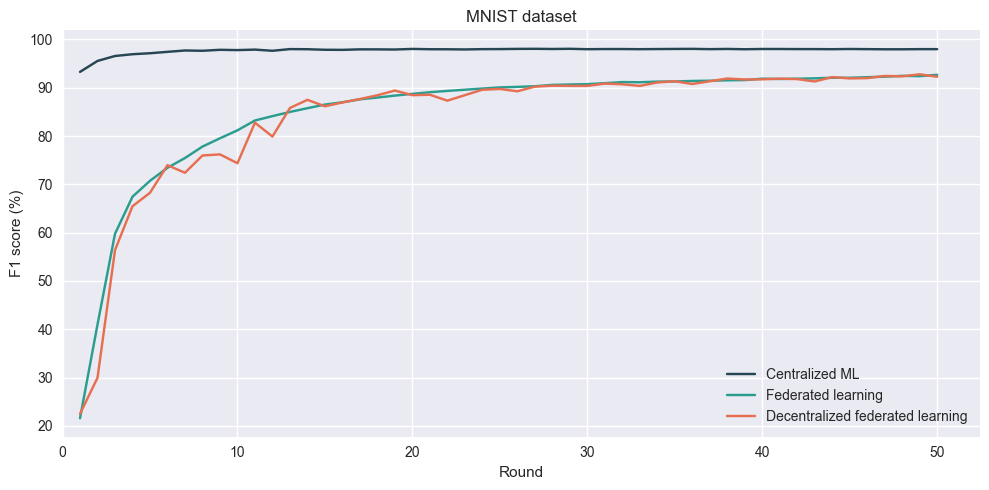

In [92]:
paths = {
    'Centralized ML': base / 'fluke_mnist_noniid_traces_centralized',
    'Federated learning': base / 'fluke_mnist_noniid_traces',
    'Decentralized federated learning': base / 'fluke_mnist_noniid_traces_FL_dec',
}
color_map = {
    'Centralized ML': '#264653',
    'Federated learning': '#2A9D8F',
    'Decentralized federated learning': '#E76F51',
}

metrics = {name: load_global_metrics(path) for name, path in paths.items()}

plt.figure(figsize=(10, 5))
for name, df in metrics.items():
    plt.plot(df['round'], df['accuracy'] * 100, label=name, color=color_map.get(name))
plt.title('MNIST dataset')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
save_fig('mnist_accuracy.png')
plt.show()

plt.figure(figsize=(10, 5))
for name, df in metrics.items():
    if 'macro_f1' in df.columns:
        plt.plot(df['round'], df['macro_f1'] * 100, label=name, color=color_map.get(name))
plt.title('MNIST dataset')
plt.xlabel('Round')
plt.ylabel('F1 score (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
save_fig('mnist_f1.png')
plt.show()


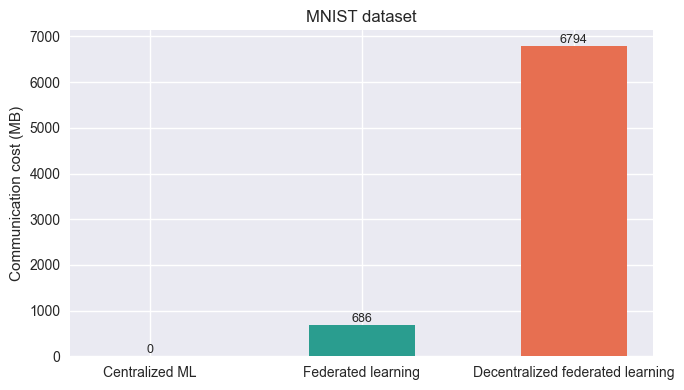

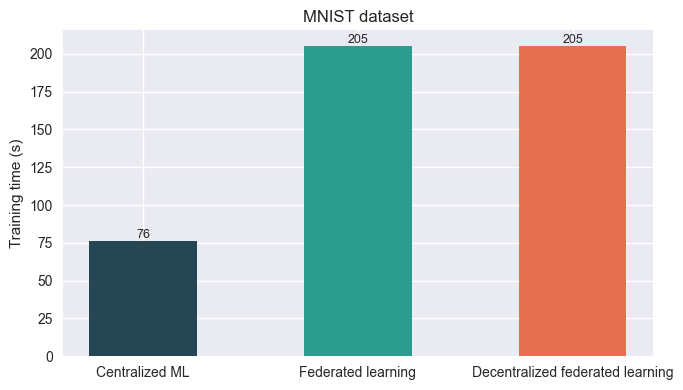

In [93]:
comm_totals = {name: comm_to_mb(load_comm_costs(path)) for name, path in paths.items()}
run_times = {name: load_run_time(path) or 0 for name, path in paths.items()}

labels = list(paths.keys())
colors = [color_map[l] for l in labels]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [comm_totals[l] for l in labels], color=colors, width=0.5)
plt.title('MNIST dataset')
plt.ylabel('Communication cost (MB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_comm_cost.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [run_times[l] for l in labels], color=colors, width=0.5)
plt.title('MNIST dataset')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_train_time.png')
plt.show()


## 2) Cost Measurement on Tabular Data
We compare **communication** and **computation** costs on a tabular dataset, using
a neural model (MLP) vs a simpler model (Logistic Regression). We will also
compare to MNIST later in the notebook.

**Runs used**:
- Adult LR (FL): `runs/adult_fedavg`
- Adult MLP (FL): `runs/adult_MLP`


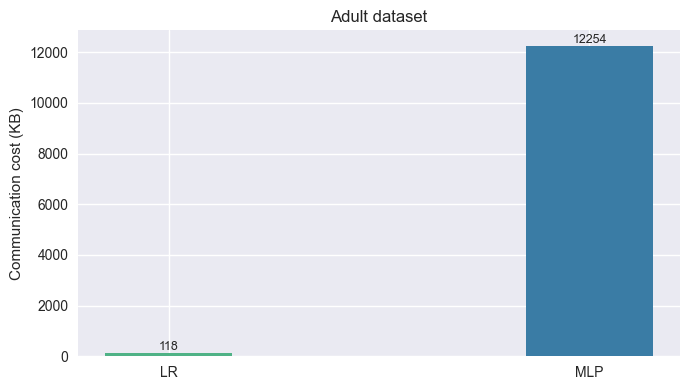

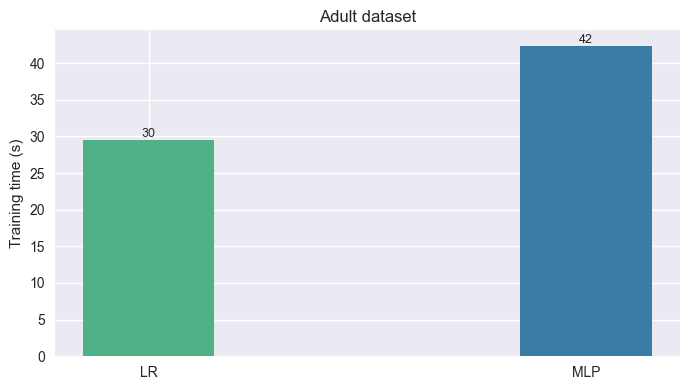

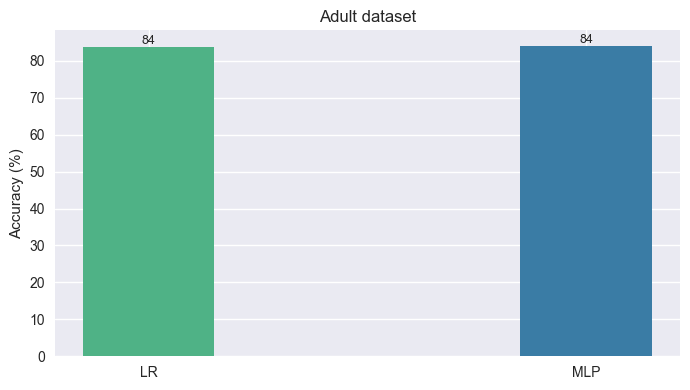

In [94]:
adult_lr_path = base / 'adult_fedavg'
adult_mlp_path = base / 'adult_MLP'

adult_lr_metrics = load_global_metrics(adult_lr_path)
adult_mlp_metrics = load_global_metrics(adult_mlp_path)

adult_lr_comm = comm_to_kb(load_comm_costs(adult_lr_path))
adult_mlp_comm = comm_to_kb(load_comm_costs(adult_mlp_path))
adult_lr_time = load_run_time(adult_lr_path) or 0
adult_mlp_time = load_run_time(adult_mlp_path) or 0

adult_lr_acc = float(adult_lr_metrics['accuracy'].iloc[-1]) * 100
adult_mlp_acc = float(adult_mlp_metrics['accuracy'].iloc[-1]) * 100

labels = ['LR', 'MLP']
colors = ['#4FB286', '#3A7CA5']

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [adult_lr_comm, adult_mlp_comm], color=colors, width=0.3)
plt.title('Adult dataset')
plt.ylabel('Communication cost (KB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('adult_lr_mlp_comm.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [adult_lr_time, adult_mlp_time], color=colors, width=0.3)
plt.title('Adult dataset')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('adult_lr_mlp_time.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [adult_lr_acc, adult_mlp_acc], color=colors, width=0.3)
plt.title('Adult dataset')
plt.ylabel('Accuracy (%)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('adult_lr_mlp.png')
plt.show()


In [ ]:
adult_lr_paths = {
    'Centralized ML': base / 'adult_centralized',
    'Federated learning': base / 'adult_fedavg',
    'Decentralized federated learning': base / 'adult_decentralized',
}

adult_lr_color_map = {
    'Centralized ML': '#264653',
    'Federated learning': '#2A9D8F',
    'Decentralized federated learning': '#E76F51',
}

adult_lr_metrics = {name: load_global_metrics(path) for name, path in adult_lr_paths.items()}

plt.figure(figsize=(10, 5))
for name, df in adult_lr_metrics.items():
    plt.plot(df['round'], df['accuracy'] * 100, label=name, color=adult_lr_color_map.get(name))
plt.title('Adult dataset')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
save_fig('adult_lr_centralized_vs_fl_vs_dec.png')
plt.show()

adult_lr_comm_totals = {name: comm_to_kb(load_comm_costs(path)) for name, path in adult_lr_paths.items()}
adult_lr_run_times = {name: load_run_time(path) or 0 for name, path in adult_lr_paths.items()}

labels = list(adult_lr_paths.keys())
colors = [adult_lr_color_map[l] for l in labels]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [adult_lr_comm_totals[l] for l in labels], color=colors, width=0.5)
plt.title('Adult dataset')
plt.ylabel('Communication cost (KB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('adult_lr_comm_cost.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [adult_lr_run_times[l] for l in labels], color=colors, width=0.5)
plt.title('Adult dataset')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('adult_lr_train_time.png')
plt.show()


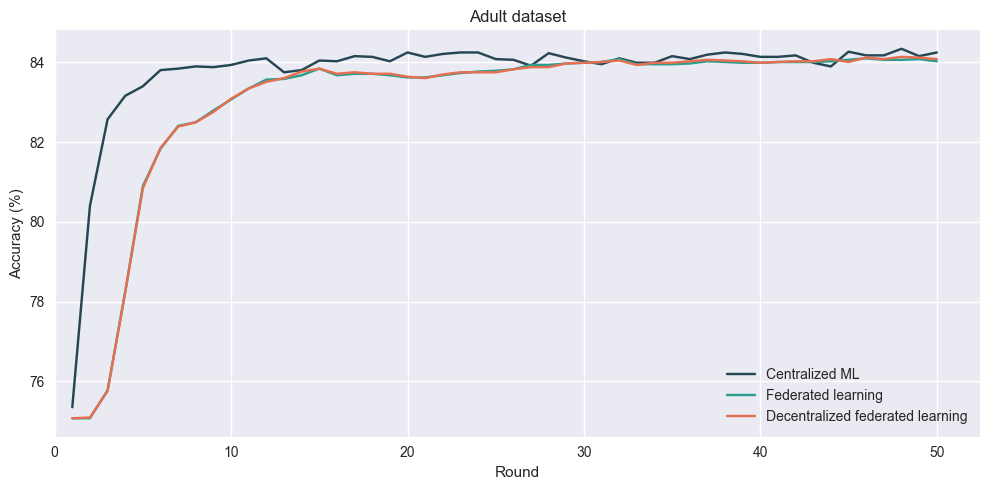

In [95]:
adult_mlp_paths = {
    'Centralized ML': base / 'adult_MLP_centralized',
    'Federated learning': base / 'adult_MLP',
    'Decentralized federated learning': base / 'adult_MLP_decentralized',
}

adult_mlp_color_map = {
    'Centralized ML': '#264653',
    'Federated learning': '#2A9D8F',
    'Decentralized federated learning': '#E76F51',
}

adult_mlp_metrics = {name: load_global_metrics(path) for name, path in adult_mlp_paths.items()}

plt.figure(figsize=(10, 5))
for name, df in adult_mlp_metrics.items():
    plt.plot(df['round'], df['accuracy'] * 100, label=name, color=adult_mlp_color_map.get(name))
plt.title('Adult dataset')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
save_fig('adult_mlp_centralized_vs_fl_vs_dec.png')
plt.show()

adult_mlp_comm_totals = {name: comm_to_kb(load_comm_costs(path)) for name, path in adult_mlp_paths.items()}
adult_mlp_run_times = {name: load_run_time(path) or 0 for name, path in adult_mlp_paths.items()}

labels = list(adult_mlp_paths.keys())
colors = [adult_mlp_color_map[l] for l in labels]

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [adult_mlp_comm_totals[l] for l in labels], color=colors, width=0.5)
plt.title('Adult dataset')
plt.ylabel('Communication cost (KB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('adult_mlp_comm_cost.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [adult_mlp_run_times[l] for l in labels], color=colors, width=0.5)
plt.title('Adult dataset')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('adult_mlp_train_time.png')
plt.show()


## Image vs tabular data  
We compare **communication** and **computation** costs on a tabular dataset, using
a neural model (Adult-MLP) vs an image dataset model using a neural network model (MNIST-MNIST_2NN).  

**Runs used**:
- Adult MLP (FL): `runs/adult_MLP`
- MNIST MNIST_2NN (FL): `runs/fluke_mnist_noniid_traces`

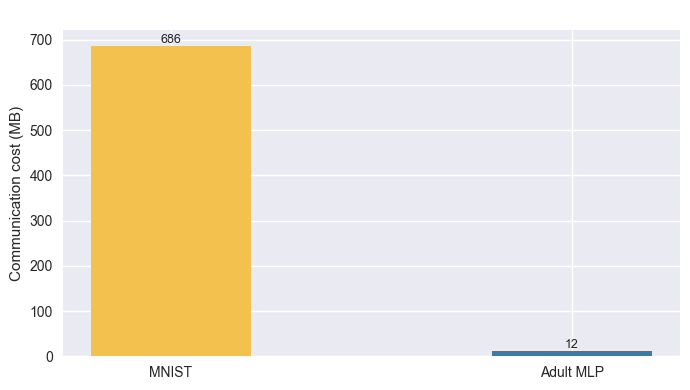

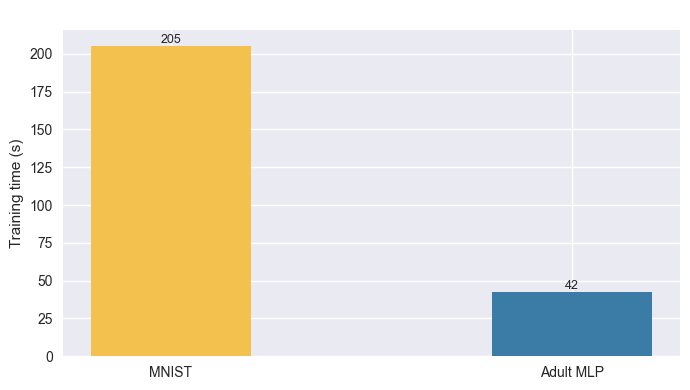

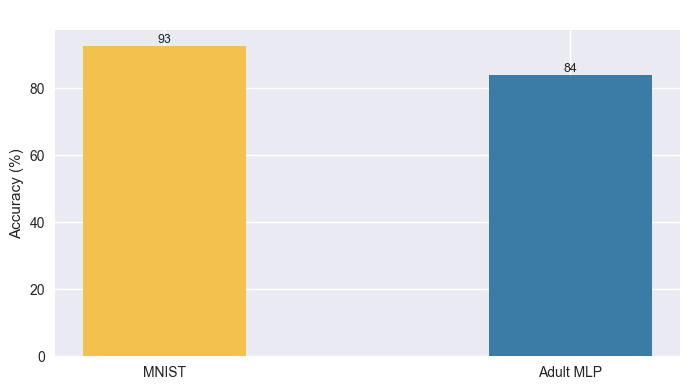

In [96]:
mnist_path = base / 'fluke_mnist_noniid_traces'
adult_mlp_path = base / 'adult_MLP'

mnist_metrics = load_global_metrics(mnist_path)
adult_mlp_metrics = load_global_metrics(adult_mlp_path)

mnist_comm = comm_to_mb(load_comm_costs(mnist_path))
adult_mlp_comm = comm_to_mb(load_comm_costs(adult_mlp_path))
mnist_time = load_run_time(mnist_path) or 0
adult_mlp_time = load_run_time(adult_mlp_path) or 0

mnist_acc = float(mnist_metrics['accuracy'].iloc[-1]) * 100
adult_mlp_acc = float(adult_mlp_metrics['accuracy'].iloc[-1]) * 100

labels = ['MNIST', 'Adult MLP']
colors = ['#F2C14E', '#3A7CA5']

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [mnist_comm, adult_mlp_comm], color=colors, width=0.4)
plt.title(' ')
plt.ylabel('Communication cost (MB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_vs_adult_mlp_comm.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [mnist_time, adult_mlp_time], color=colors, width=0.4)
plt.title(' ')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_vs_adult_mlp_time.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(labels, [mnist_acc, adult_mlp_acc], color=colors, width=0.4)
plt.title(' ')
plt.ylabel('Accuracy (%)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_vs_adult_mlp.png')
plt.show()


### Cost‑to‑Accuracy  
We compute time‑to‑accuracy and communication‑to‑accuracy at 70/80/90/100% of the final accuracy.

### Adult LR vs Adult MLP

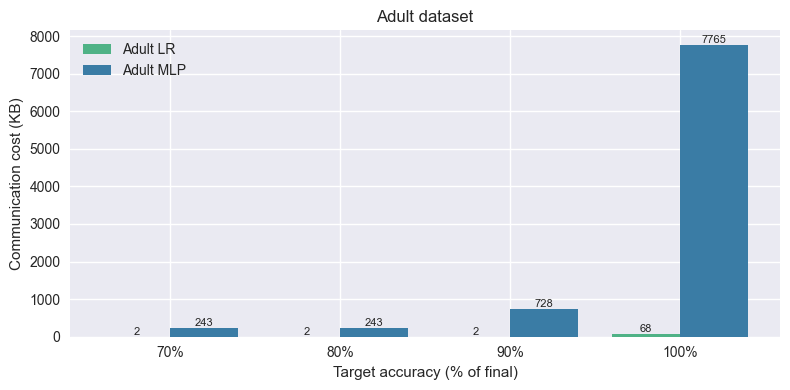

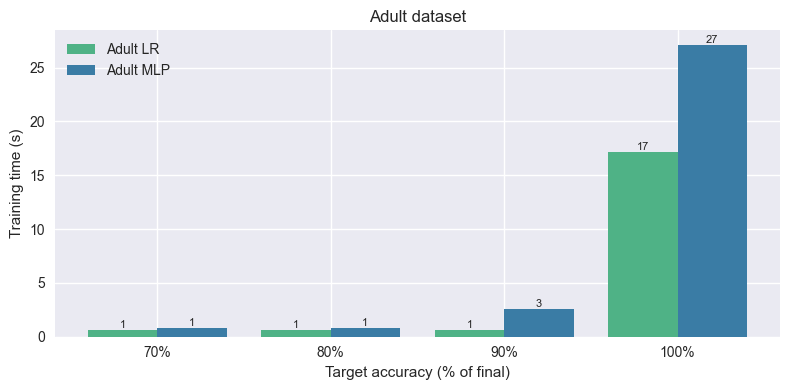

In [97]:
thresholds = [0.7, 0.8, 0.9, 1.0]
threshold_labels = ['70%', '80%', '90%', '100%']

def _comm_until(comm_df, target_round, unit='KB'):
    if comm_df is None or comm_df.empty:
        return 0
    total = comm_df[comm_df['round'] <= target_round]['comm_costs'].sum()
    bytes_per_param = 4
    if unit == 'KB':
        return (total * bytes_per_param) / 1024
    return (total * bytes_per_param) / (1024**2)

def compute_cost_to_accuracy(run_path, comm_unit='KB'):
    metrics_df = load_global_metrics(run_path)
    acc = metrics_df['accuracy'] * 100
    final_acc = float(acc.iloc[-1])
    round_vals = metrics_df['round'].astype(int)

    comm_df = load_comm_costs(run_path)
    run_time = load_run_time(run_path) or 0
    max_round = int(round_vals.max()) if len(round_vals) else 0
    time_per_round = (run_time / max_round) if max_round > 0 else 0

    comm_to_acc = []
    time_to_acc = []
    for t in thresholds:
        target = final_acc * t
        reached = round_vals[acc >= target]
        if reached.empty:
            comm_to_acc.append(float('nan'))
            time_to_acc.append(float('nan'))
            continue
        r = int(reached.iloc[0])
        comm_to_acc.append(_comm_until(comm_df, r, unit=comm_unit))
        time_to_acc.append(time_per_round * r)

    return comm_to_acc, time_to_acc

def plot_cost_to_accuracy(run_map, title, comm_unit='KB', colors=None, save_prefix=None):
    if colors is None:
        colors = ['#3A7CA5', '#4FB286']
    keys = list(run_map.keys())
    comm_data = []
    time_data = []
    for k in keys:
        comm_vals, time_vals = compute_cost_to_accuracy(run_map[k], comm_unit=comm_unit)
        comm_data.append(comm_vals)
        time_data.append(time_vals)

    x = range(len(thresholds))
    width = 0.8 / max(1, len(keys))

    plt.figure(figsize=(8, 4))
    for i, (k, vals) in enumerate(zip(keys, comm_data)):
        bars = plt.bar([xi + i * width for xi in x], vals, width=width, label=k, color=colors[i % len(colors)])
        for bar in bars:
            height = bar.get_height()
            if height == height:
                plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    plt.title(title)
    plt.xlabel('Target accuracy (% of final)')
    plt.ylabel(f'Communication cost ({comm_unit})')
    plt.xticks([xi + width * (len(keys) - 1) / 2 for xi in x], threshold_labels)
    plt.legend()
    plt.tight_layout()
    if save_prefix:
        save_fig(f'{save_prefix}.png')
        save_fig(f'{save_prefix}_comm.png')
    plt.show()

    plt.figure(figsize=(8, 4))
    for i, (k, vals) in enumerate(zip(keys, time_data)):
        bars = plt.bar([xi + i * width for xi in x], vals, width=width, label=k, color=colors[i % len(colors)])
        for bar in bars:
            height = bar.get_height()
            if height == height:
                plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    plt.title(title)
    plt.xlabel('Target accuracy (% of final)')
    plt.ylabel('Training time (s)')
    plt.xticks([xi + width * (len(keys) - 1) / 2 for xi in x], threshold_labels)
    plt.legend()
    plt.tight_layout()
    if save_prefix:
        save_fig(f'{save_prefix}_time.png')
    plt.show()

adult_compare = {
    'Adult LR': adult_lr_path,
    'Adult MLP': adult_mlp_path,
}
plot_cost_to_accuracy(adult_compare, 'Adult dataset', comm_unit='KB', colors=['#4FB286', '#3A7CA5'], save_prefix='adult_cost_to_accuracy')


### MNIST MNIST_2NN vs Adult MLP

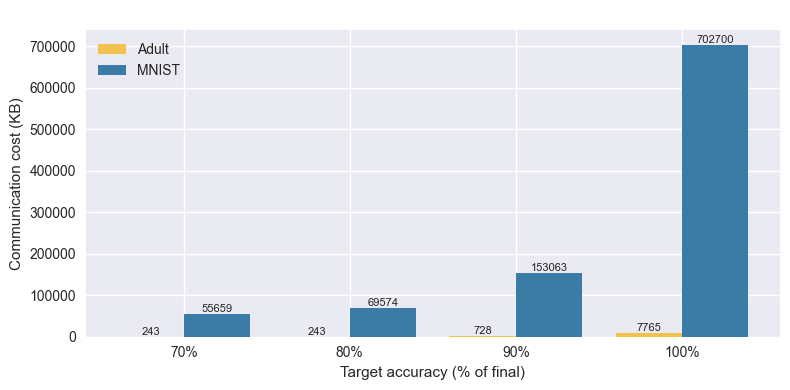

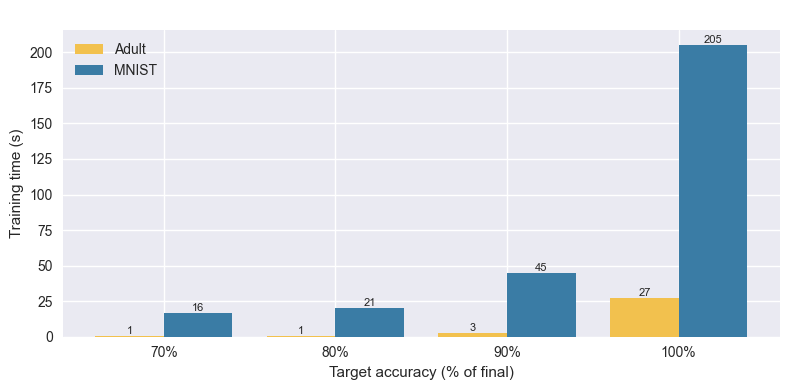

In [ ]:
mnist_adult_compare = {
    'Adult': adult_mlp_path,
    'MNIST': base / 'fluke_mnist_noniid_traces',
}
plot_cost_to_accuracy(mnist_adult_compare, ' ', comm_unit='KB', colors=['#3A7CA5', '#F2C14E'], save_prefix='mnist_vs_adult_cost_to_accuracy')


## 3) Advanced Cost Analysis (FL)
We evaluate FL costs under different **local epochs** and **client selection rates**.
For each setting, we show communication cost, training time, and accuracy.

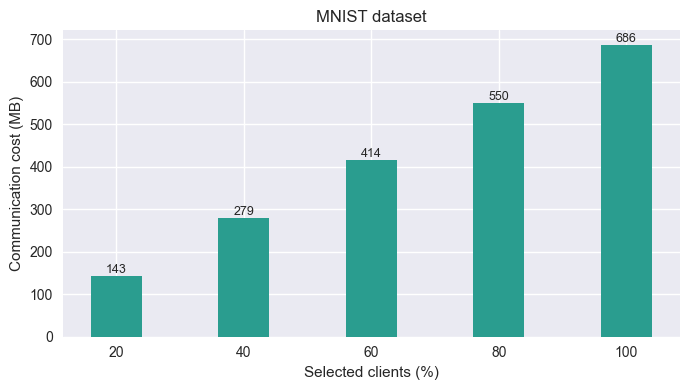

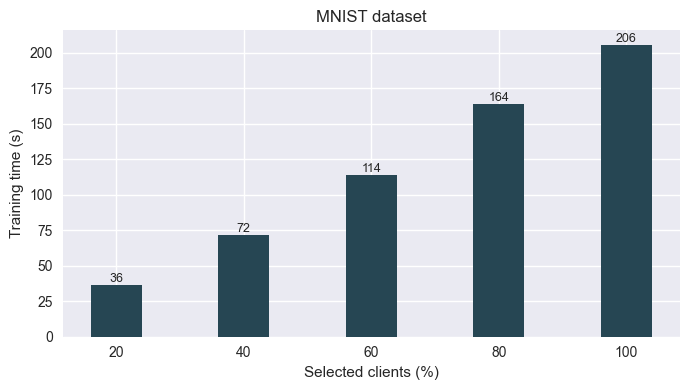

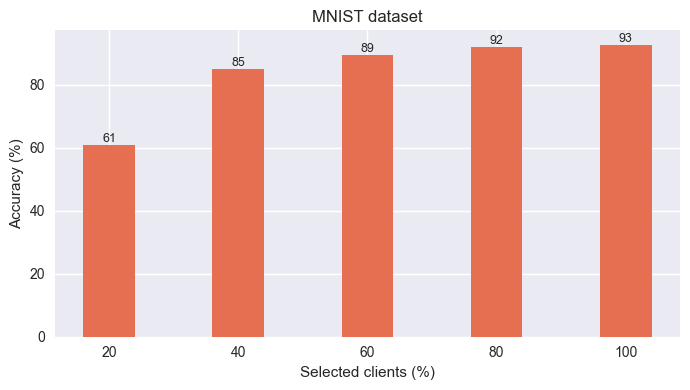

In [99]:
client_paths = {
    20: base / 'fluke_mnist_noniid_traces-cl-20',
    40: base / 'fluke_mnist_noniid_traces-cl-40',
    60: base / 'fluke_mnist_noniid_traces-cl-60',
    80: base / 'fluke_mnist_noniid_traces-cl-80',
    100: base / 'fluke_mnist_noniid_traces-cl-100',
}

cl_comm = {}
cl_time = {}
cl_acc = {}
for k, path in client_paths.items():
    comm_df = load_comm_costs(path)
    cl_comm[k] = comm_to_mb(comm_df)
    cl_time[k] = load_run_time(path) or 0
    metrics_df = load_global_metrics(path)
    cl_acc[k] = float(metrics_df['accuracy'].iloc[-1]) * 100

x = sorted(client_paths.keys())

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [cl_comm[v] for v in x], color='#2A9D8F', width=0.4)
plt.title('MNIST dataset')
plt.xlabel('Selected clients (%)')
plt.ylabel('Communication cost (MB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_selected_clients_comm.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [cl_time[v] for v in x], color='#264653', width=0.4)
plt.title('MNIST dataset')
plt.xlabel('Selected clients (%)')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_selected_clients_time.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [cl_acc[v] for v in x], color='#E76F51', width=0.4)
plt.title('MNIST dataset')
plt.xlabel('Selected clients (%)')
plt.ylabel('Accuracy (%)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_selected_clients_acc.png')
plt.show()


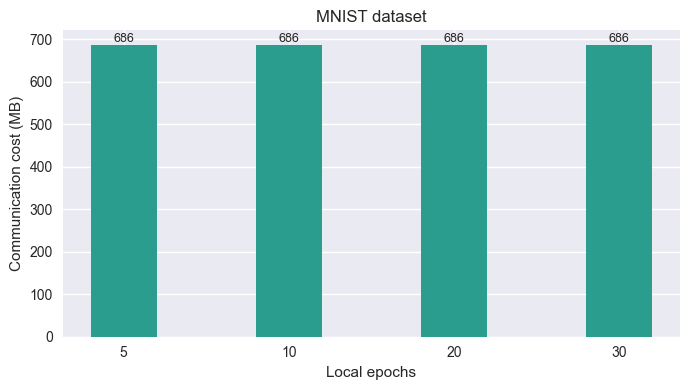

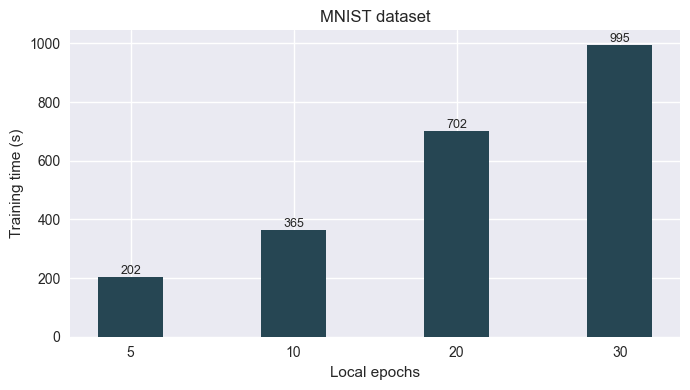

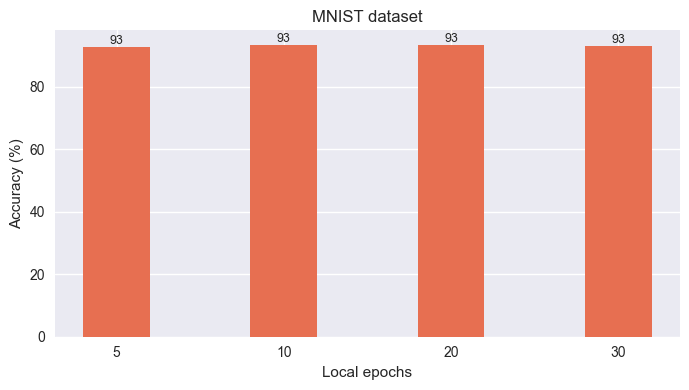

In [100]:
lep_paths = {
    5: base / 'fluke_mnist_noniid_traces-lep-5',
    10: base / 'fluke_mnist_noniid_traces-lep-10',
    20: base / 'fluke_mnist_noniid_traces-lep-20',
    30: base / 'fluke_mnist_noniid_traces-lep-30',
}

lep_comm = {}
lep_time = {}
lep_acc = {}
for k, path in lep_paths.items():
    comm_df = load_comm_costs(path)
    lep_comm[k] = comm_to_mb(comm_df)
    lep_time[k] = load_run_time(path) or 0
    metrics_df = load_global_metrics(path)
    lep_acc[k] = float(metrics_df['accuracy'].iloc[-1]) * 100

x = sorted(lep_paths.keys())

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [lep_comm[v] for v in x], color='#2A9D8F', width=0.4)
plt.title('MNIST dataset')
plt.xlabel('Local epochs')
plt.ylabel('Communication cost (MB)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_local_epochs_comm.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [lep_time[v] for v in x], color='#264653', width=0.4)
plt.title('MNIST dataset')
plt.xlabel('Local epochs')
plt.ylabel('Training time (s)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_local_epochs_time.png')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar([str(v) for v in x], [lep_acc[v] for v in x], color='#E76F51', width=0.4)
plt.title('MNIST dataset')
plt.xlabel('Local epochs')
plt.ylabel('Accuracy (%)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
save_fig('mnist_local_epochs_acc.png')
plt.show()
